In [1]:
import tensorflow as tf
print(tf.__version__)

2.6.0


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
from google.colab import drive
drive.mount('/content/drive/', force_remount=True)

Mounted at /content/drive/


In [4]:
import os, re, time, json
import PIL.Image, PIL.ImageFont, PIL.ImageDraw
import numpy as np
from matplotlib import pyplot as plt
import tensorflow_datasets as tfds
import cv2

In [5]:
data_dir = "/content/drive/My Drive/TF3 C3 W1 Data/"

In [6]:
def draw_bounding_box_on_image(image, ymin, xmin, ymax, xmax, color=(255, 0, 0), thickness=5):
    image_width = image.shape[1]
    image_height = image.shape[0]
    cv2.rectangle(image, (int(xmin), int(ymin)), (int(xmax), int(ymax)), color, thickness)


def draw_bounding_boxes_on_image(image, boxes, color=[], thickness=5):
    boxes_shape = boxes.shape
    if not boxes_shape:
        return
    if len(boxes_shape) != 2 or boxes_shape[1] != 4:
        raise ValueError('Input must be of size [N, 4]')
    for i in range(boxes_shape[0]):
        draw_bounding_box_on_image(image, boxes[i, 1], boxes[i, 0], boxes[i, 3],
                                 boxes[i, 2], color[i], thickness)


def draw_bounding_boxes_on_image_array(image, boxes, color=[], thickness=5):
    draw_bounding_boxes_on_image(image, boxes, color, thickness)
  
    return image

In [7]:
plt.rc('image', cmap='gray')
plt.rc('grid', linewidth=0)
plt.rc('xtick', top=False, bottom=False, labelsize='large')
plt.rc('ytick', left=False, right=False, labelsize='large')
plt.rc('axes', facecolor='F8F8F8', titlesize="large", edgecolor='white')
plt.rc('text', color='a8151a')
plt.rc('figure', facecolor='F0F0F0')
MATPLOTLIB_FONT_DIR = os.path.join(os.path.dirname(plt.__file__), "mpl-data/fonts/ttf")

def display_digits_with_boxes(images, pred_bboxes, bboxes, iou, title, bboxes_normalized=False):

    n = len(images)

    fig = plt.figure(figsize=(20, 4))
    plt.title(title)
    plt.yticks([])
    plt.xticks([])
  
    for i in range(n):
      ax = fig.add_subplot(1, 10, i+1)
      bboxes_to_plot = []
      if (len(pred_bboxes) > i):
        bbox = pred_bboxes[i]
        bbox = [bbox[0] * images[i].shape[1], bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0]]
        bboxes_to_plot.append(bbox)
    
      if (len(bboxes) > i):
        bbox = bboxes[i]
        if bboxes_normalized == True:
          bbox = [bbox[0] * images[i].shape[1],bbox[1] * images[i].shape[0], bbox[2] * images[i].shape[1], bbox[3] * images[i].shape[0] ]
        bboxes_to_plot.append(bbox)

      img_to_draw = draw_bounding_boxes_on_image_array(image=images[i], boxes=np.asarray(bboxes_to_plot), color=[(255,0,0), (0, 255, 0)])
      plt.xticks([])
      plt.yticks([])
    
      plt.imshow(img_to_draw)

      if len(iou) > i :
        color = "black"
        if (iou[i][0] < iou_threshold):
          color = "red"
        ax.text(0.2, -0.3, "iou: %s" %(iou[i][0]), color=color, transform=ax.transAxes)
        
       
def plot_metrics(metric_name, title, ylim=5):
    plt.title(title)
    plt.ylim(0,ylim)
    plt.plot(history.history[metric_name],color='blue',label=metric_name)
    plt.plot(history.history['val_' + metric_name],color='green',label='val_' + metric_name)

In [8]:
def read_image_tfds(image, bbox):
    image = tf.cast(image, tf.float32)
    shape = tf.shape(image)

    factor_x = tf.cast(shape[1], tf.float32)
    factor_y = tf.cast(shape[0], tf.float32)

    image = tf.image.resize(image, (224, 224,))

    image = image/127.5
    image -= 1

    bbox_list = [bbox[0] / factor_x , 
                 bbox[1] / factor_y, 
                 bbox[2] / factor_x , 
                 bbox[3] / factor_y]
    
    return image, bbox_list

In [9]:
def read_image_with_shape(image, bbox):
    original_image = image
    
    image, bbox_list = read_image_tfds(image, bbox)
    
    return original_image, image, bbox_list

In [10]:
def read_image_tfds_with_original_bbox(data):
    image = data["image"]
    bbox = data["bbox"]

    shape = tf.shape(image)
    factor_x = tf.cast(shape[1], tf.float32) 
    factor_y = tf.cast(shape[0], tf.float32)

    bbox_list = [bbox[1] * factor_x , 
                 bbox[0] * factor_y, 
                 bbox[3] * factor_x, 
                 bbox[2] * factor_y]
    return image, bbox_list

In [11]:
def dataset_to_numpy_util(dataset, batch_size=0, N=0):
    take_dataset = dataset.shuffle(1024)

    if batch_size > 0:
        take_dataset = take_dataset.batch(batch_size)
  
    if N > 0:
        take_dataset = take_dataset.take(N)
  
    if tf.executing_eagerly():
        ds_images, ds_bboxes = [], []
        for images, bboxes in take_dataset:
            ds_images.append(images.numpy())
            ds_bboxes.append(bboxes.numpy())
        
    return (np.array(ds_images), np.array(ds_bboxes))

In [12]:
def dataset_to_numpy_with_original_bboxes_util(dataset, batch_size=0, N=0):

    normalized_dataset = dataset.map(read_image_with_shape)
    if batch_size > 0:
        normalized_dataset = normalized_dataset.batch(batch_size)
  
    if N > 0:
        normalized_dataset = normalized_dataset.take(N)

    if tf.executing_eagerly():
        ds_original_images, ds_images, ds_bboxes = [], [], []
        
    for original_images, images, bboxes in normalized_dataset:
        ds_images.append(images.numpy())
        ds_bboxes.append(bboxes.numpy())
        ds_original_images.append(original_images.numpy())

    return np.array(ds_original_images), np.array(ds_images), np.array(ds_bboxes)

tfds.core.DatasetInfo(
    name='caltech_birds2010',
    version=0.1.1,
    description='Caltech-UCSD Birds 200 (CUB-200) is an image dataset with photos 
of 200 bird species (mostly North American). The total number of 
categories of birds is 200 and there are 6033 images in the 2010 
dataset and 11,788 images in the 2011 dataset.
Annotations include bounding boxes, segmentation labels.',
    homepage='http://www.vision.caltech.edu/visipedia/CUB-200.html',
    features=FeaturesDict({
        'bbox': BBoxFeature(shape=(4,), dtype=tf.float32),
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=200),
        'label_name': Text(shape=(), dtype=tf.string),
        'segmentation_mask': Image(shape=(None, None, 1), dtype=tf.uint8),
    }),
    total_num_examples=6033,
    splits={
        'test': 3033,
        'train': 3000,
    },
    supervised_keys=('ima

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


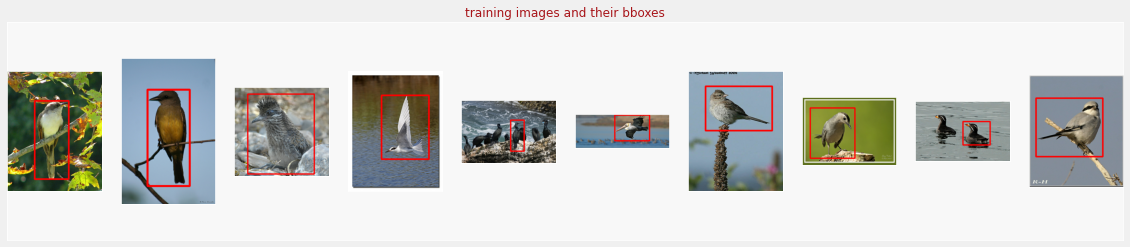

In [13]:
def get_visualization_training_dataset():      
    dataset, info = tfds.load("caltech_birds2010", split="train", with_info=True, data_dir=data_dir, download=False)
    print(info)
    visualization_training_dataset = dataset.map(read_image_tfds_with_original_bbox, 
                                                 num_parallel_calls=16)
    return visualization_training_dataset


visualization_training_dataset = get_visualization_training_dataset()


(visualization_training_images, visualization_training_bboxes) = dataset_to_numpy_util(visualization_training_dataset, N=10)
display_digits_with_boxes(np.array(visualization_training_images), np.array([]), np.array(visualization_training_bboxes), np.array([]), "training images and their bboxes")

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


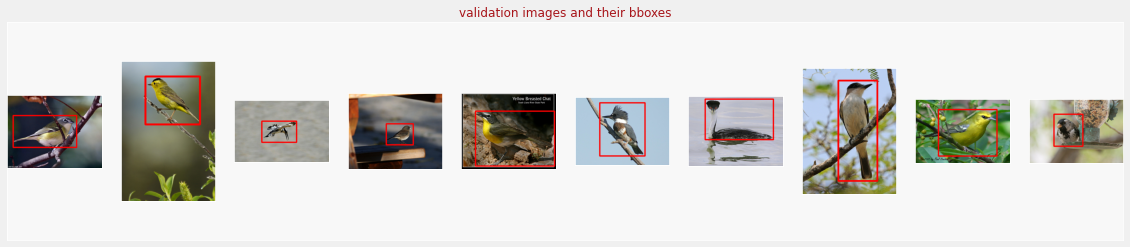

In [14]:
def get_visualization_validation_dataset():
    dataset = tfds.load("caltech_birds2010", split="test", data_dir=data_dir, download=False)
    visualization_validation_dataset = dataset.map(read_image_tfds_with_original_bbox, num_parallel_calls=16)
    return visualization_validation_dataset


visualization_validation_dataset = get_visualization_validation_dataset()

(visualization_validation_images, visualization_validation_bboxes) = dataset_to_numpy_util(visualization_validation_dataset, N=10)
display_digits_with_boxes(np.array(visualization_validation_images), np.array([]), np.array(visualization_validation_bboxes), np.array([]), "validation images and their bboxes")

In [15]:
BATCH_SIZE = 64

def get_training_dataset(dataset):
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.shuffle(512, reshuffle_each_iteration=True)
    dataset = dataset.repeat()
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(-1) 
    return dataset

def get_validation_dataset(dataset):
    dataset = dataset.map(read_image_tfds, num_parallel_calls=16)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.repeat()
    return dataset

training_dataset = get_training_dataset(visualization_training_dataset)
validation_dataset = get_validation_dataset(visualization_validation_dataset)

In [16]:
def feature_extractor(inputs):

    mobilenet_model = tf.keras.applications.mobilenet_v2.MobileNetV2(input_shape=(224,224,3),include_top=False,weights='imagenet')
    feature_extractor = mobilenet_model(inputs)
    return feature_extractor

In [17]:
def dense_layers(features):
    x = tf.keras.layers.AveragePooling2D()(features)     
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(1024,activation='relu')(x)
    x = tf.keras.layers.Dense(512,activation='relu')(x)
    
    return x

In [18]:
def bounding_box_regression(x):
    bounding_box_regression_output = tf.keras.layers.Dense(4,name='bounding_box')(x)
    return bounding_box_regression_output

In [19]:
def final_model(inputs):

    feature_cnn = feature_extractor(inputs)

    last_dense_layer = dense_layers(feature_cnn)

    bounding_box_output = bounding_box_regression(last_dense_layer)

    model = tf.keras.Model(inputs=inputs,outputs=bounding_box_output)

    return model

In [20]:
def define_and_compile_model():
    inputs = tf.keras.layers.Input(shape=(224,224,3))
    model = final_model(inputs)
    model.compile(optimizer=tf.keras.optimizers.SGD(momentum=0.9),loss=tf.keras.losses.MeanSquaredError())
    return model

In [21]:
model = define_and_compile_model()
model.summary()

9420800/9406464 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
mobilenetv2_1.00_224 (Functi (None, 7, 7, 1280)        2257984   
_________________________________________________________________
average_pooling2d (AveragePo (None, 3, 3, 1280)        0         
_________________________________________________________________
flatten (Flatten)            (None, 11520)             0         
_________________________________________________________________
dense (Dense)                (None, 1024)              11797504  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
________________________________________________________________

In [22]:

EPOCHS = 50
BATCH_SIZE = 64
length_of_training_dataset = len(visualization_training_dataset)

length_of_validation_dataset = len(visualization_validation_dataset)

if(length_of_training_dataset%BATCH_SIZE==0):
  steps_per_epoch = length_of_training_dataset//BATCH_SIZE
else:
  steps_per_epoch=(length_of_training_dataset//BATCH_SIZE)+1
validation_steps = length_of_validation_dataset//BATCH_SIZE
if length_of_validation_dataset % BATCH_SIZE > 0:
    validation_steps += 1

In [23]:
history = model.fit(training_dataset,steps_per_epoch=steps_per_epoch,validation_data=validation_dataset,validation_steps=validation_steps,epochs=EPOCHS)

Epoch 1/50
47/47 [==============================] - 99s 1s/step - loss: 0.9823 - val_loss: 1523.8053
Epoch 2/50
47/47 [==============================] - 56s 1s/step - loss: 0.0200 - val_loss: 749.2076
Epoch 3/50
47/47 [==============================] - 47s 1s/step - loss: 0.0166 - val_loss: 441.7747
Epoch 4/50
47/47 [==============================] - 48s 1s/step - loss: 0.0149 - val_loss: 241.0954
Epoch 5/50
47/47 [==============================] - 52s 1s/step - loss: 0.0138 - val_loss: 130.6988
Epoch 6/50
47/47 [==============================] - 48s 1s/step - loss: 0.0129 - val_loss: 71.7839
Epoch 7/50
47/47 [==============================] - 47s 1s/step - loss: 0.0120 - val_loss: 41.1052
Epoch 8/50
47/47 [==============================] - 52s 1s/step - loss: 0.0115 - val_loss: 24.6884
Epoch 9/50
47/47 [==============================] - 47s 1s/step - loss: 0.0109 - val_loss: 14.0201
Epoch 10/50
47/47 [==============================] - 52s 1s/step - loss: 0.0102 - val_loss: 7.4486
Epoc

In [24]:
loss = model.evaluate(validation_dataset, steps=validation_steps)
print("Loss: ", loss)

48/48 [==============================] - 16s 321ms/step - loss: 0.0181
Loss:  0.018050417304039


In [25]:
model.save("birds.h5")

/usr/local/lib/python3.7/dist-packages/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


In [26]:
from google.colab import files
#files.download("birds.h5")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

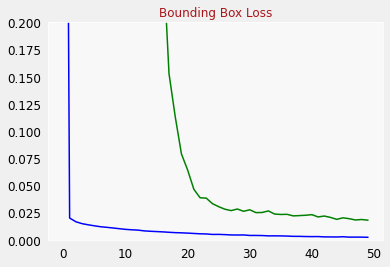

In [27]:
plot_metrics("loss", "Bounding Box Loss", ylim=0.2)

In [28]:
def intersection_over_union(pred_box, true_box):

    xmin_pred, ymin_pred, xmax_pred, ymax_pred =  np.split(pred_box, 4, axis = 1)
    xmin_true, ymin_true, xmax_true, ymax_true = np.split(true_box, 4, axis = 1)

    xmin_overlap = np.maximum(xmin_pred, xmin_true)
    xmax_overlap = np.minimum(xmax_pred, xmax_true)
    ymin_overlap = np.maximum(ymin_pred, ymin_true)
    ymax_overlap = np.minimum(ymax_pred, ymax_true)

    pred_box_area = (xmax_pred - xmin_pred) * (ymax_pred - ymin_pred)
    true_box_area = (xmax_true - xmin_true) * (ymax_true - ymin_true)

    overlap_area = np.maximum((xmax_overlap - xmin_overlap),0)  * np.maximum((ymax_overlap - ymin_overlap), 0)
    union_area = (pred_box_area + true_box_area) - overlap_area

    smoothing_factor = 1e-10

    iou = (overlap_area + smoothing_factor) / (union_area + smoothing_factor)

    return iou

original_images, normalized_images, normalized_bboxes = dataset_to_numpy_with_original_bboxes_util(visualization_validation_dataset, N=500)
predicted_bboxes = model.predict(normalized_images, batch_size=32)

iou = intersection_over_union(predicted_bboxes, normalized_bboxes)
iou_threshold = 0.5

print("Number of predictions where iou > threshold(%s): %s" % (iou_threshold, (iou >= iou_threshold).sum()))
print("Number of predictions where iou < threshold(%s): %s" % (iou_threshold, (iou < iou_threshold).sum()))

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:18: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray


Number of predictions where iou > threshold(0.5): 212
Number of predictions where iou < threshold(0.5): 288


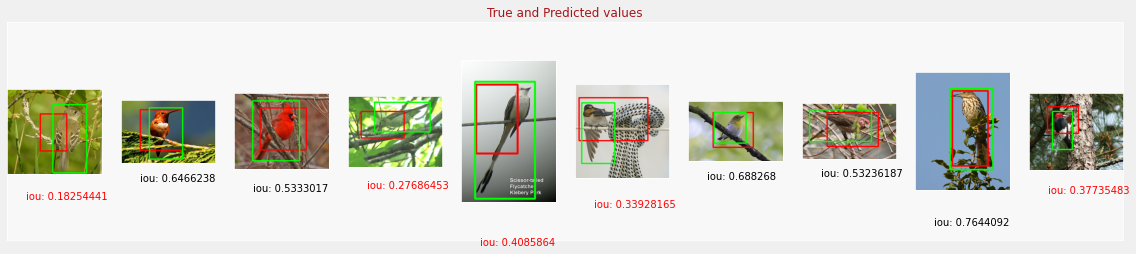

In [29]:
n = 10
indexes = np.random.choice(len(predicted_bboxes), size=n)

iou_to_draw = iou[indexes]
norm_to_draw = original_images[indexes]
display_digits_with_boxes(original_images[indexes], predicted_bboxes[indexes], normalized_bboxes[indexes], iou[indexes], "True and Predicted values", bboxes_normalized=True)